<a href="https://colab.research.google.com/github/e-mcgeorge/e-mcgeorge/blob/main/forwards_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install fenics

Set up fenics to virtual ubuntu machine.

Dolfin-adjoint automatically derives the discrete adjoint and tangent linear models from a forward model written in the Python interface to FEniCS and Firedrake.

Mount google drive. Path is:

    '/content/drive/My Drive/[folder]/[filename]'



In [ ]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
  from fenics import *; from dolfin import *; from mshr import *; from fenics_adjoint import *
except ImportError as e:
  try:
    from fenics import *; from dolfin import *; from mshr import *
  except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from fenics import *; from dolfin import *; from mshr import *
  !pip install git+https://bitbucket.org/dolfin-adjoint/pyadjoint.git@2019.1.0
  from fenics_adjoint import *;
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

#!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

E: Package 'python-software-properties' has no installation candidate
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Hit:11 http://ppa.launchpad.net/graphics-drivers/pp

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
# drive.mount('/content/drive', force_remount = True)
drive.mount('/content/drive')

# From here on save stuff to location: '/content/drive/My Drive/Colab Notebooks/[filename]'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Install cbc post: cbcpost is developed to simplify the postprocessing of 
# simulation results, produced by FEniCS solvers.
!pip install git+https://bitbucket.org/simula_cbc/cbcpost.git

  Cloning https://bitbucket.org/simula_cbc/cbcpost.git to /tmp/pip-req-build-w3citacx
  Running command git clone -q https://bitbucket.org/simula_cbc/cbcpost.git /tmp/pip-req-build-w3citacx
  Created wheel for cbcpost: filename=cbcpost-2016.1.0-cp36-none-any.whl size=123309 sha256=e7146b1ae018526a093b3876508c80f3da7ed16f278714b8ddf87f6a2306bbc4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ekosm8_e/wheels/56/1e/cf/bf54befc039a37454db569fd80d6a3f80e0b8e405ab0ed5b63
Successfully built cbcpost


# Forwards 0: Linear stationary Poisson

In [ ]:
# Test problem:
import sympy as sym
x, y = sym.symbols('x[0], x[1]') # This will give the write form of the equations for c++ encoding
u = (1/(2*sym.pi**2)) * sym.sin(sym.pi*x)*sym.sin(sym.pi*y)
kappa = 1
f = -1 * kappa * sym.diff(sym.diff(u,x),x) + -1 * sym.diff(sym.diff(u,y),y)
print('u = ', u)
print('-kappa *grad^2(u)) = f = ', f)

u_code = sym.printing.ccode(u)
f_code = sym.printing.ccode(f)

u =  sin(pi*x[0])*sin(pi*x[1])/(2*pi**2)
-kappa *grad^2(u)) = f =  sin(pi*x[0])*sin(pi*x[1])


In [ ]:
# LINEAR stationary optimal control

"""
FEniCS tutorial demo program: Nonlinear Poisson equation.
  -kappa*grad^2(u)) = f   in the unit square.
                  u = u_D on the boundary.
"""

from __future__ import print_function

# Warning: from fenics import * will import both `sym` and
# `q` from FEniCS. We therefore import FEniCS first and then
# overwrite these objects.
from dolfin import *

# Create mesh and define function space
mesh = UnitSquareMesh(100, 100)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('0', degree = 2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = Function(V)  # Note: not TrialFunction!
v = TestFunction(V)
f = Expression(f_code, degree=1)
k = Constant(1)
F = k*dot(grad(u), grad(v))*dx - f*v*dx

# Compute solution
solve(F == 0, u, bc)

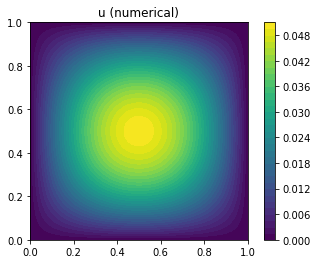

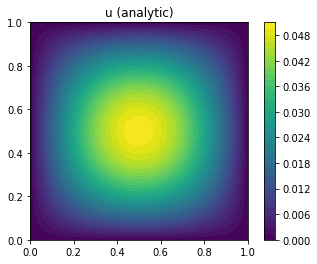

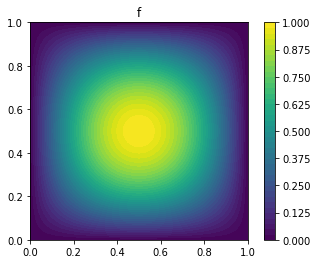

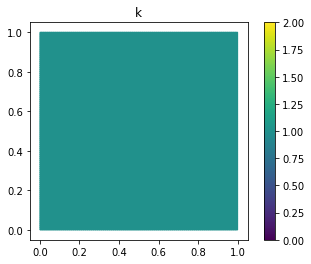

In [ ]:
# Plots of numerical solution and analytical solution
import matplotlib.pyplot as plt

# Plot 1: Numerical solution
plt.figure()
p1 = plot(u)
plt.title('u (numerical)')
plt.colorbar(p1)

# Plot 2: Analytic solution
# First, project the analytic solution onto our mesh for plotting
u_analytic = interpolate(Expression(u_code, degree=2), V)
plt.figure()
p2 = plot(u_analytic)
plt.title('u (analytic)')
plt.colorbar(p2)

# Plot 3: forcing function
f1 = interpolate(f, V)
plt.figure()
p3 = plot(f1)
plt.title('f')
plt.colorbar(p3)

# Plot 4: thermal diffusivity
k1 = interpolate(k, V)
plt.figure()
p4 = plot(k1, mesh=mesh, mode='color', vmin=0, vmax=2)
plt.title('k')
plt.colorbar(p4)


In [ ]:
# Save numerical solution to drive
File('/content/drive/My Drive/Colab Notebooks/inverse_practice/observation_data/f0_mesh_obs.xml') << mesh
File('/content/drive/My Drive/Colab Notebooks/inverse_practice/observation_data/f0_u_obs.xml') << u
File('/content/drive/My Drive/Colab Notebooks/inverse_practice/observation_data/f0_f_obs.xml') << f1
File('/content/drive/My Drive/Colab Notebooks/inverse_practice/observation_data/f0_k_obs.xml') << k1

# Forwards 1: Non-linear stationary Poisson

In [ ]:
# Test problem:
import sympy as sym
x, y = sym.symbols('x[0], x[1]') # This will give the write form of the equations for c++ encoding
u = 1 + x + 2*y
q = 1+2*u
f = -1 * sym.diff(q*sym.diff(u,x),x) + -1 * sym.diff(q*sym.diff(u,y),y)
print('u = ', u)
print('q = 2u + 1 = ', q)
print('-grad(q(u) grad(u)) = f = ', f)

u_code = sym.printing.ccode(u)
f_code = sym.printing.ccode(f)

u =  x[0] + 2*x[1] + 1
q = 2u + 1 =  2*x[0] + 4*x[1] + 3
-grad(q(u) grad(u)) = f =  -10


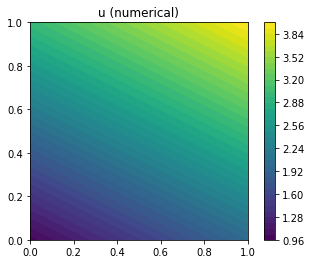

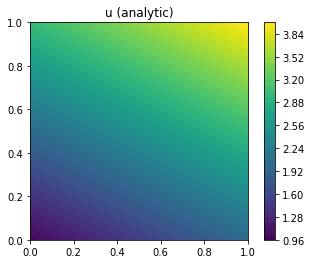

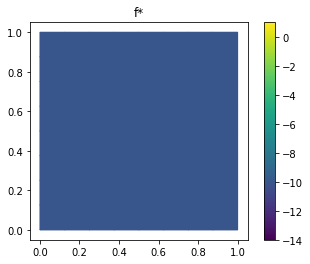

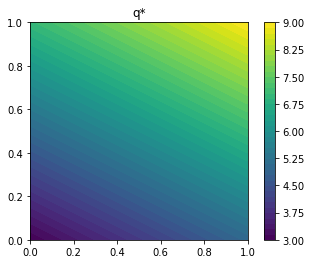

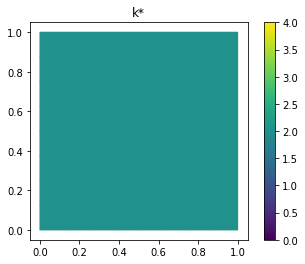

In [ ]:
# NON-LINEAR PROBLEMS

"""
FEniCS tutorial demo program: Nonlinear Poisson equation.
  -div(q(u)*grad(u)) = f   in the unit square.
                   u = u_D on the boundary.
"""

from __future__ import print_function

# Warning: from fenics import * will import both `sym` and
# `q` from FEniCS. We therefore import FEniCS first and then
# overwrite these objects.
from fenics import *
from dolfin import *
import sympy as sym

def q(u,k):
    "Return nonlinear coefficient"
    return 1 + k*u

# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0] + 2*x[1]', degree = 2)
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = Function(V)  # Note: not TrialFunction!
v = TestFunction(V)
f = Expression('-10', degree=1)
k = Expression('2', degree=1)
F = q(u,k)*dot(grad(u), grad(v))*dx - f*v*dx

# Compute solution
solve(F == 0, u, bc)

# Plots of numerical solution and analytical solution
import matplotlib.pyplot as plt

# Plot 1: Numerical solution
plt.figure()
p1 = plot(u)
plt.title('u (numerical)')
plt.colorbar(p1)

# Plot 2: Analytic solution
# First, project the analytic solution onto our mesh for plotting
u_analytic = interpolate(Expression('x[0] + 2*x[1] + 1', degree=2), V)
plt.figure()
p2 = plot(u_analytic)
plt.title('u (analytic)')
plt.colorbar(p2)

# Plot 3: forcing function
f1 = interpolate(f, V)
plt.figure()
p3 = plot(f1, mesh=mesh, mode='color', vmin=1, vmax=-14)
plt.title('f*')
plt.colorbar(p3)

# PLot 4: Final q(u)
q1 = interpolate(project(q(u,k),V), V)
plt.figure()
p4 = plot(q1)
plt.title('q*')
plt.colorbar(p4)

# Plot 5: value for k
k1 = interpolate(k, V)
plt.figure()
p = plot(k1, mesh=mesh, mode='color', vmin=0, vmax=4)
plt.title('k*')
plt.colorbar(p)

# Save numerical solution to drive
File('/content/drive/My Drive/Colab Notebooks/inverse_practice/observation_data/f1_mesh_obs.xml') << mesh
File('/content/drive/My Drive/Colab Notebooks/inverse_practice/observation_data/f1_u_obs.xml') << u
File('/content/drive/My Drive/Colab Notebooks/inverse_practice/observation_data/f1_f_obs.xml') << f1
File('/content/drive/My Drive/Colab Notebooks/inverse_practice/observation_data/f1_q_obs.xml') << q1
File('/content/drive/My Drive/Colab Notebooks/inverse_practice/observation_data/f1_k_obs.xml') << k1

# Forwards 2: Linear non-stationary Poisson

This example follows 3.1 the Heat Equation from The Fenics Tutorial and 1.3.1 of "Automated Solution of Differential Equations by the Finite Element Method"

See both references for a comprehensive guide on how this works.


In [ ]:
# TIME DEPENDENT PROBLEMS


from fenics import *
import numpy as np
import scipy as sp
from __future__ import print_function
import matplotlib.pyplot as plt

# Set parameters
T = 2.0                   # Total time to run the program for
num_time_steps = 10       # Number of time steps
dt = T / num_time_steps   # Calculate dt
alpha = 3                 # Set parameters
beta = 1.2                # Set parameters
gamma = 1                 # gamma = 1: const source, gamma = 2: time dep source

# Create a mesh and define the function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)   # Create a mesh on the unit square [0,1] x [0,1]
V = FunctionSpace(mesh, 'P', 1) # This uses degree 1 polynomials as the approximating functions

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*pow(t, gamma)',
                 degree=2, alpha=alpha, beta=beta, gamma = gamma, t=0)
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)

# Define test and trial functions
u = TrialFunction(V)
v = TestFunction(V)
f = Expression('gamma*beta*pow(t,gamma-1) - 2 - 2*alpha', 
               degree = 1, alpha = alpha, beta = beta, gamma = gamma, t = 0)

# Construct a and L, this method asks fenics to choose which terms from F should be in a or L
F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx

# Perform the time stepping in a loop
u = Function(V)
t = 0
for n in range(num_time_steps):

    # update time
    t += dt
    u_D.t = t
    f.t = t

    # Solve variational problem
    solve(F==0, u, bc)

    u_n.assign(u)

# Plot solution and mesh
plt.figure(figsize=(15,4)) # Make big
p1 = plot(u)
p2 = plot(mesh)
plt.colorbar(p1);
plt.legend(['Finite element solution', 'Finite element mesh'], loc='upper left')

ModuleNotFoundError: ignored

In [ ]:
# Save numerical solution to drive
File('/content/drive/My Drive/inverse_practice/problem_2/f2_fconst_saved_mesh.xml') << mesh
File('/content/drive/My Drive/inverse_practice/problem_2/f2_fconst_saved_u.xml') << u

f1 = project(f, V)
File('/content/drive/My Drive/inverse_practice/problem_2/f2_fconst_saved_f.xml') << f1

In [ ]:
# Check that the files have been saved/created
ls "/content/drive/My Drive/inverse_practice/problem_2"

f2_timedep_saved_f.xml  f2_timedep_saved_mesh.xml  f2_timedep_saved_u.xml


In [ ]:
# ******************************************************************************
# Data
# ******************************************************************************
# This reads in the output from the forwards problem. By giving the original 
# mesh used, we can change function space
mesh_data3 = Mesh('/content/drive/My Drive/inverse_practice/f2234_timedep_saved_mesh.xml') # Gets mesh from file
V_data1 = FunctionSpace(mesh_data3, 'P', 1) # Need this for reading in u)
u_data1 = Function(V_data1, '/content/drive/My Drive/inverse_practice/f22_timedep_saved_u.xml')

plot(mesh_data3)

# Forwards 3: Non-linear and non-stationary Poisson

In [ ]:
# COMBINED TIME DEPENDENT NON LINEAR: My attempt

"""
Liz's practice: Nonlinear time dependent Poisson equation.
  du/dt = div(q(u)*grad(u)) + f   in the unit square.
                   u = u_D = 0 on the boundary.

  We set u, u_0, q(u) and f:
      f = 6             on Omega x (0, T]
      q(u) = 1 + u^2    on Omega x (0, T]
      u = u_0 = 0           at t = 0
      u = 1 + x + 2*y

"""

from __future__ import print_function
import matplotlib.pyplot as plt

# Warning: from fenics import * will import both `sym` and
# `q` from FEniCS. We therefore must import FEniCS first and then
# overwrite these objects.
from fenics import *

# Set parameters
T = 2.0                   # Total time to run the program for
num_time_steps = 10       # Number of time steps
dt = T / num_time_steps   # Calculate dt

def q(u):
    "Return nonlinear coefficient"
    return 1 + u**2

# Use SymPy to compute RHS from the manufactured solution u and f
import sympy as sym
x, y = sym.symbols('x[0], x[1]')
u = 1 + x + 2*y
non_linear_term = sym.diff(q(u)*sym.diff(u, x), x) + sym.diff(q(u)*sym.diff(u, y), y)
f = 6
non_linear_term_code = sym.printing.ccode(non_linear_term)
f_code = sym.printing.ccode(f)
print('grad(q(u) grad u) =', non_linear_term_code)
print('f =', f_code)


# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)   # Create a mesh on the unit square [0,1] x [0,1]
V = FunctionSpace(mesh, 'P', 1) # This uses degree 1 polynomials as the approximating functions

# Plot of mesh
p1 = plot(mesh)

# Define boundary condition
u_D = Constant(0)
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_0 = interpolate(u_D, V)

# Define variational problem
u = Function(V)  # Note: not TrialFunction!
v = TestFunction(V)
f = Expression(f_code, degree = 0)
u_n = u_0
F = u*v*dx + dt*q(u)*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx

# # Alternatively:
# # Construct a and L, this method asks fenics to choose which terms from F should be in a or L
# F = u*v*dx + dt*q(u)*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
# a, L = lhs(F), rhs(F)
# Then use solve(a == L, u, bc)

# Perform the time stepping in a loop
t = 0
for n in range(num_time_steps):

    # Update time
    t += dt

    # Solve variational problem
    solve(F == 0, u, bc)

    # # Plot solution
    # plot(u)

    # Compute error at vertices
    #u_e = interpolate(u_D, V)
    #error = np.abs(u_e.vector().array() - u.vector().array()).max()
    #print('t = %.2f: error = %.3g' % (t, error))

    # Update solution
    u_n.assign(u)


# Plot solution and mesh, as well as print some details

print('time = ', t)

plt.figure(figsize=(15,4)) # Make big
p2 = plot(u)
p3 = plot(mesh)
plt.colorbar(p2);
plt.legend(['Finite element solution', 'Finite element mesh'], loc='upper left')

